In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from typing import Tuple
from scipy.stats import pearsonr
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler

In [3]:
def rank_biserial_correlation(x: pd.Series, y: pd.Series) -> Tuple[float, str]:
    """
    Compute rank-biserial correlation from two independent samples.
    """

    nx = len(x)
    ny = len(y)

    U, _ = mannwhitneyu(x, y, alternative='two-sided')
    rbc = 1 - (2 * U) / (nx * ny)

    abs_rbc = abs(rbc)
    if abs_rbc < 0.1:
        interpretation = "negligible"
    elif abs_rbc < 0.3:
        interpretation = "small"
    elif abs_rbc < 0.5:
        interpretation = "medium"
    else:
        interpretation = "large"

    return rbc, interpretation

In [4]:
def cliffs_delta(x: pd.Series, y: pd.Series) -> Tuple[float, str]:
    """
    Compute Cliff's Delta and return interpretation.
    """
    nx = len(x)
    ny = len(y)
    greater = sum(xi > yj for xi in x for yj in y)
    less = sum(xi < yj for xi in x for yj in y)
    delta = (greater - less) / (nx * ny)

    abs_delta = abs(delta)
    if abs_delta < 0.147:
        interpretation = "negligible"
    elif abs_delta < 0.33:
        interpretation = "small"
    elif abs_delta < 0.474:
        interpretation = "medium"
    else:
        interpretation = "large"
    return delta, interpretation

In [5]:
def classify_cortisol_level(value):
    if value > 20:
        return "High"
    elif value < 10:
        return "Low"
    else:
        return "Moderate"

In [7]:
df_data_iga = pd.read_csv("../processed_data/6_processed_data_iga_analyzed_with_predictions.csv")
print(df_data_iga.shape)
df_data_iga.head(5)

(35, 15)


,ID,Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment,Group,Variability_Profile,sIgA_Level_Profile_Morning,sIgA_Level_Profile_Afternoon,sIgA-Change,Attachment_binary
0,1,Male,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure,Insecure - Male,Low/Moderate,Low sIgA,Low sIgA,No Change,1
1,4,Male,28.473065,50.881961,22.408896,3.348951,3.687484,0.338533,Secure,Secure - Male,Low/Moderate,Low sIgA,Moderate sIgA,Increase,0
2,5,Female,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure,Secure - Female,Low/Moderate,High sIgA,Moderate sIgA,Decrease,0
3,7,Female,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure,Insecure - Female,Low/Moderate,Low sIgA,Moderate sIgA,Increase,1
4,12,Female,29.554870,45.078186,15.523316,3.368950,3.587869,0.218919,Secure,Secure - Female,Low/Moderate,Low sIgA,Moderate sIgA,Increase,0


In [8]:
df_data_cortisol = pd.read_csv("../processed_data/4_processed_data_cortisol.csv")
print(df_data_cortisol.shape)
df_data_cortisol.head(5)

(8, 10)


,ID,Cortisol (pg/mL),Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment
0,16.0,3.59,Female,57.476955,73.891936,16.414980,3.974519,4.178677,0.204158,Secure
1,32.0,22.75,Male,32.565326,44.611069,12.045743,3.417520,3.749981,0.332461,Secure
2,1.0,5.62,Male,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure
3,7.0,1.83,Female,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure
4,5.0,2.28,Female,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure


In [9]:
df_merge = df_data_iga.merge(right=df_data_cortisol, on="ID")
df_merge.shape

(8, 24)

In [10]:
df_merge.head(5)

,ID,Gender_x,sIgA_Average_Morning_x,sIgA_Average_Afternoon_x,sIgA_Average_Difference_x,sIgA_Average_Morning_log_x,sIgA_Average_Afternoon_log_x,sIgA_Average_Difference_log_x,Attachment_x,Group,...,Attachment_binary,Cortisol (pg/mL),Gender_y,sIgA_Average_Morning_y,sIgA_Average_Afternoon_y,sIgA_Average_Difference_y,sIgA_Average_Morning_log_y,sIgA_Average_Afternoon_log_y,sIgA_Average_Difference_log_y,Attachment_y
0,1,Male,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure,Insecure - Male,...,1,5.62,Male,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure
1,5,Female,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure,Secure - Female,...,0,2.28,Female,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure
2,7,Female,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure,Insecure - Female,...,1,1.83,Female,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure
3,16,Female,57.476955,73.891936,16.414980,3.974519,4.178677,0.204158,Secure,Secure - Female,...,0,3.59,Female,57.476955,73.891936,16.414980,3.974519,4.178677,0.204158,Secure
4,23,Female,80.824884,47.632842,-33.192041,4.392023,3.846883,-0.545141,Secure,Secure - Female,...,0,4.76,Female,80.824884,47.632842,-33.192041,4.392023,3.846883,-0.545141,Secure


In [11]:
df_merge.columns

Index(['ID', 'Gender_x', 'sIgA_Average_Morning_x', 'sIgA_Average_Afternoon_x',
       'sIgA_Average_Difference_x', 'sIgA_Average_Morning_log_x',
       'sIgA_Average_Afternoon_log_x', 'sIgA_Average_Difference_log_x',
       'Attachment_x', 'Group', 'Variability_Profile',
       'sIgA_Level_Profile_Morning', 'sIgA_Level_Profile_Afternoon',
       'sIgA-Change', 'Attachment_binary', 'Cortisol (pg/mL)', 'Gender_y',
       'sIgA_Average_Morning_y', 'sIgA_Average_Afternoon_y',
       'sIgA_Average_Difference_y', 'sIgA_Average_Morning_log_y',
       'sIgA_Average_Afternoon_log_y', 'sIgA_Average_Difference_log_y',
       'Attachment_y'],
      dtype='object')

In [14]:
df_merge = df_merge[['ID', 'Group', 'Variability_Profile',
       'sIgA_Level_Profile_Morning', 'sIgA_Level_Profile_Afternoon',
       'sIgA-Change', 'Attachment_binary', 'Cortisol (pg/mL)', 'Gender_y',
       'sIgA_Average_Morning_y', 'sIgA_Average_Afternoon_y',
       'sIgA_Average_Difference_y', 'sIgA_Average_Morning_log_y',
       'sIgA_Average_Afternoon_log_y', 'sIgA_Average_Difference_log_y',
       'Attachment_y']]

df_merge.columns = ['ID', 'Group', 'Variability_Profile',
       'sIgA_Level_Profile_Morning', 'sIgA_Level_Profile_Afternoon',
       'sIgA-Change', 'Attachment_binary', 'Cortisol (pg/mL)', 'Gender',
       'sIgA_Average_Morning', 'sIgA_Average_Afternoon',
       'sIgA_Average_Difference', 'sIgA_Average_Morning_log',
       'sIgA_Average_Afternoon_log', 'sIgA_Average_Difference_log',
       'Attachment']
df_merge.head(5)

,ID,Group,Variability_Profile,sIgA_Level_Profile_Morning,sIgA_Level_Profile_Afternoon,sIgA-Change,Attachment_binary,Cortisol (pg/mL),Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment
0,1,Insecure - Male,Low/Moderate,Low sIgA,Low sIgA,No Change,1,5.62,Male,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure
1,5,Secure - Female,Low/Moderate,High sIgA,Moderate sIgA,Decrease,0,2.28,Female,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure
2,7,Insecure - Female,Low/Moderate,Low sIgA,Moderate sIgA,Increase,1,1.83,Female,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure
3,16,Secure - Female,Low/Moderate,Moderate sIgA,Moderate sIgA,No Change,0,3.59,Female,57.476955,73.891936,16.414980,3.974519,4.178677,0.204158,Secure
4,23,Secure - Female,Low/Moderate,Moderate sIgA,Moderate sIgA,No Change,0,4.76,Female,80.824884,47.632842,-33.192041,4.392023,3.846883,-0.545141,Secure


In [15]:
df_merge[df_merge["Attachment"] == "Secure"]["Cortisol (pg/mL)"].median()

3.59

In [16]:
df_merge[df_merge["Attachment"] == "Insecure"]["Cortisol (pg/mL)"].median()

5.62

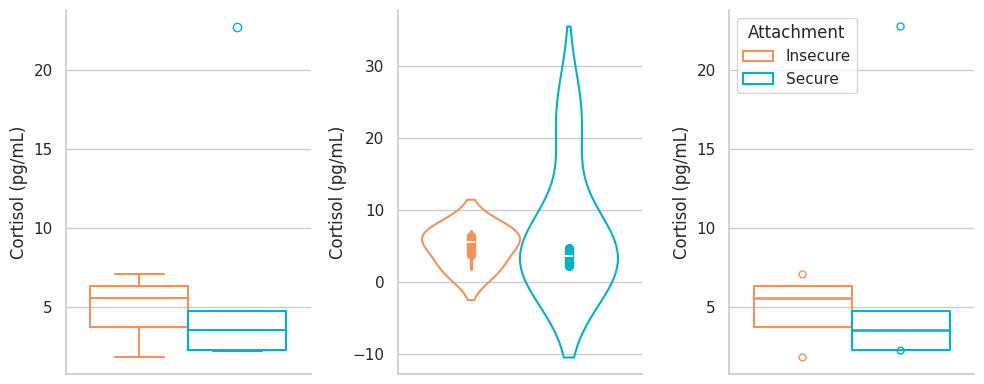

In [17]:
sns.set(style="whitegrid", font_scale=1)

palette = {"Secure": "#00B2CA", "Insecure": "#F79256"}

f, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)

sns.boxplot(
    data=df_merge, 
    y="Cortisol (pg/mL)", 
    hue="Attachment", 
    ax=axes[0], 
    fill=False,
    palette=palette, 
    legend=False)

sns.violinplot(
    data=df_merge, 
    y="Cortisol (pg/mL)", 
    hue="Attachment", 
    ax=axes[1], 
    fill=False, 
    palette=palette,
    legend=False)

sns.boxenplot(
    data=df_merge, 
    y="Cortisol (pg/mL)", 
    hue="Attachment", 
    ax=axes[2], 
    palette=palette,
    fill=False)

sns.despine()
plt.tight_layout()

In [18]:
variables = ["Cortisol (pg/mL)"]

attachment_comparison = []
for var in variables:
    secure_vals = df_merge[df_merge["Attachment"] == "Secure"][var]
    insecure_vals = df_merge[df_merge["Attachment"] == "Insecure"][var]
    stat, p = mannwhitneyu(secure_vals, insecure_vals, alternative='two-sided')
    statistic_result = {"variable": var, "U statistic": stat, "p-value": p}
    attachment_comparison.append(statistic_result)

attachment_comparison = pd.DataFrame(attachment_comparison)
attachment_comparison["reject"] = attachment_comparison["p-value"]<=0.05
attachment_comparison

,variable,U statistic,p-value,reject
0,Cortisol (pg/mL),7.0,1.0,False


In [19]:
attachment_cliffs = []
for var in variables:
    secure_vals = df_merge[df_merge["Attachment"] == "Secure"][var]
    insecure_vals = df_merge[df_merge["Attachment"] == "Insecure"][var]
    delta, interp = cliffs_delta(secure_vals, insecure_vals)
    attachment_cliffs.append({"variable": var, "Cliff's Delta": delta, "Interpretation": interp})

attachment_cliffs = pd.DataFrame(attachment_cliffs)
attachment_cliffs

,variable,Cliff's Delta,Interpretation
0,Cortisol (pg/mL),-0.066667,negligible


In [20]:
rbc_attachment = []
for var in variables:
    secure_vals = df_merge[df_merge["Attachment"] == "Secure"][var]
    insecure_vals = df_merge[df_merge["Attachment"] == "Insecure"][var]
    rbc, interp = rank_biserial_correlation(secure_vals, insecure_vals)
    rbc_attachment.append({"variable": var, "Rank-Biserial Corr": rbc, "Interpretation": interp})
rbc_attachment = pd.DataFrame(rbc_attachment)
rbc_attachment

,variable,Rank-Biserial Corr,Interpretation
0,Cortisol (pg/mL),0.066667,negligible


In [21]:
attachment_comparison.merge(right=attachment_cliffs, on="variable").merge(right=rbc_attachment, on="variable")

,variable,U statistic,p-value,reject,Cliff's Delta,Interpretation_x,Rank-Biserial Corr,Interpretation_y
0,Cortisol (pg/mL),7.0,1.0,False,-0.066667,negligible,0.066667,negligible


In [22]:
df_merge["Variability_Profile"].value_counts()

Variability_Profile
Low/Moderate    8
Name: count, dtype: int64

In [23]:
df_merge["sIgA_Level_Profile_Morning"].value_counts()

sIgA_Level_Profile_Morning
Moderate sIgA    4
Low sIgA         3
High sIgA        1
Name: count, dtype: int64

In [24]:
df_merge["sIgA_Level_Profile_Morning"] = df_merge["sIgA_Level_Profile_Morning"].replace({'High sIgA' : 'Moderate sIgA'})

In [25]:
df_merge["sIgA_Level_Profile_Afternoon"].value_counts()

sIgA_Level_Profile_Afternoon
Moderate sIgA    6
Low sIgA         2
Name: count, dtype: int64

In [26]:
df_merge["sIgA-Change"].value_counts()

sIgA-Change
No Change    6
Decrease     1
Increase     1
Name: count, dtype: int64

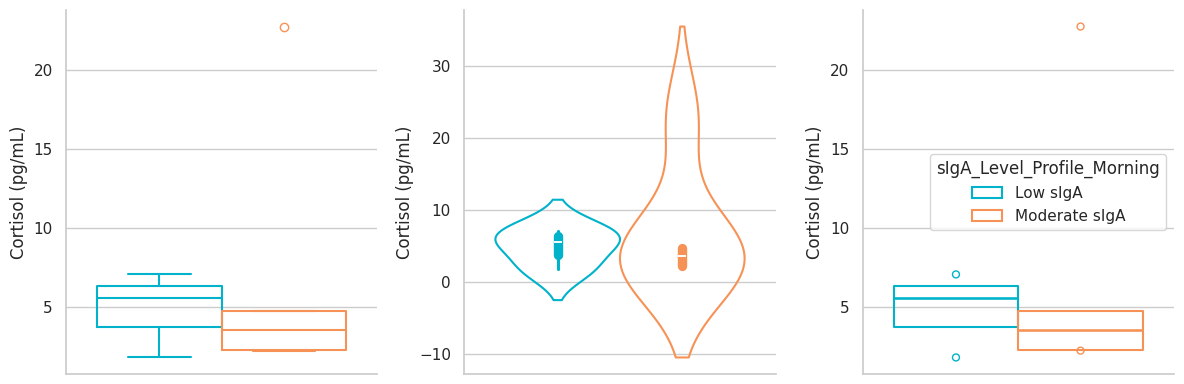

In [27]:
sns.set(style="whitegrid", font_scale=1)

palette = {"Low sIgA": "#00B2CA", "Moderate sIgA": "#F79256"}

f, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True)

sns.boxplot(
    data=df_merge, 
    y="Cortisol (pg/mL)", 
    hue="sIgA_Level_Profile_Morning", 
    ax=axes[0], 
    fill=False,
    palette=palette, 
    legend=False)

sns.violinplot(
    data=df_merge, 
    y="Cortisol (pg/mL)", 
    hue="sIgA_Level_Profile_Morning", 
    ax=axes[1], 
    fill=False, 
    palette=palette,
    legend=False)

sns.boxenplot(
    data=df_merge, 
    y="Cortisol (pg/mL)", 
    hue="sIgA_Level_Profile_Morning", 
    ax=axes[2], 
    palette=palette,
    fill=False)

sns.despine()
plt.tight_layout()

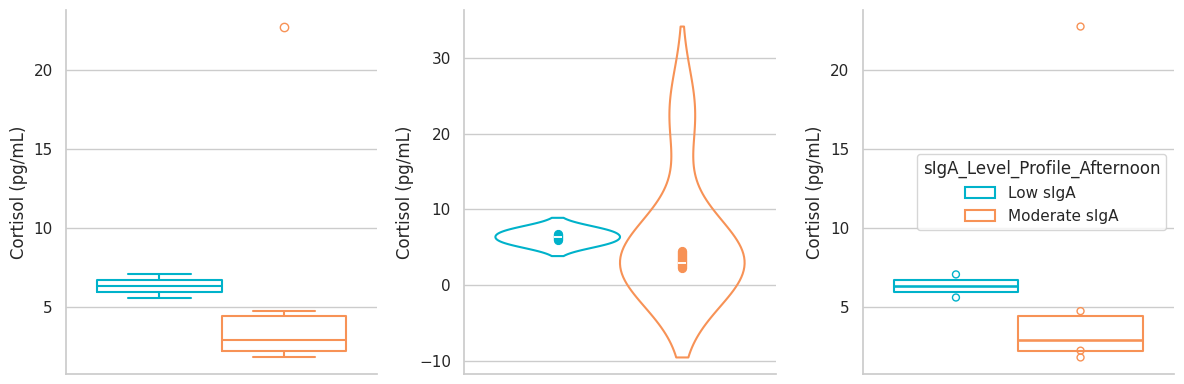

In [28]:
sns.set(style="whitegrid", font_scale=1)

palette = {"Low sIgA": "#00B2CA", "Moderate sIgA": "#F79256"}

f, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True)

sns.boxplot(
    data=df_merge, 
    y="Cortisol (pg/mL)", 
    hue="sIgA_Level_Profile_Afternoon", 
    ax=axes[0], 
    fill=False,
    palette=palette, 
    legend=False)

sns.violinplot(
    data=df_merge, 
    y="Cortisol (pg/mL)", 
    hue="sIgA_Level_Profile_Afternoon", 
    ax=axes[1], 
    fill=False, 
    palette=palette,
    legend=False)

sns.boxenplot(
    data=df_merge, 
    y="Cortisol (pg/mL)", 
    hue="sIgA_Level_Profile_Afternoon", 
    ax=axes[2], 
    palette=palette,
    fill=False)

sns.despine()
plt.tight_layout()

In [29]:
df_merge["Cortisol_Level"] = df_merge["Cortisol (pg/mL)"].apply(classify_cortisol_level)
df_merge["Cortisol_Level"].value_counts()

Cortisol_Level
Low     7
High    1
Name: count, dtype: int64

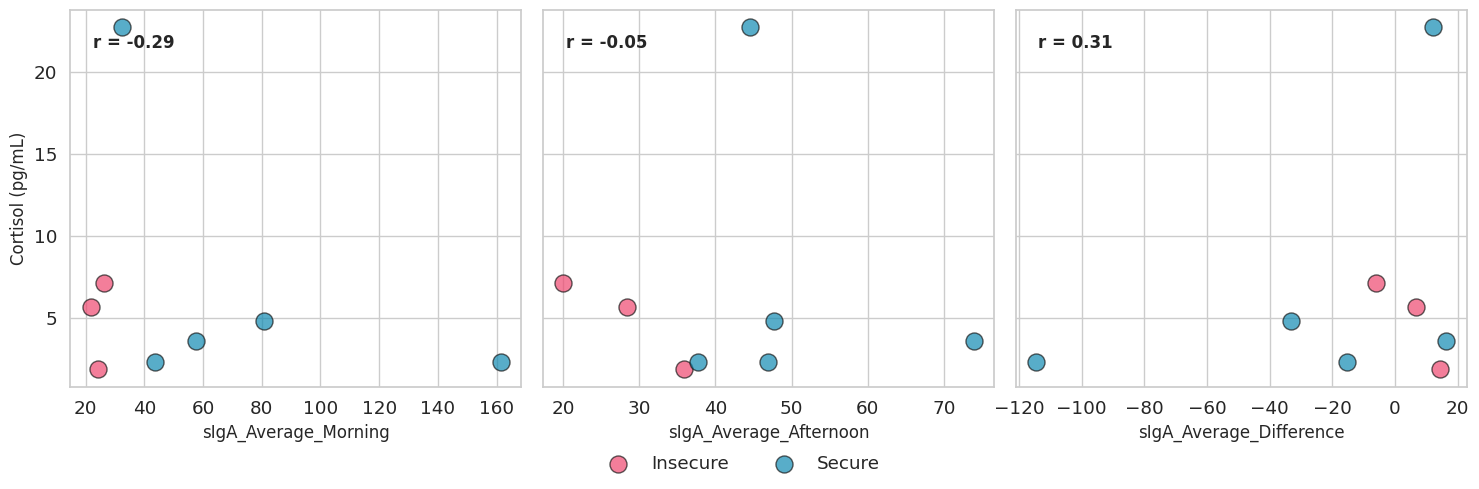

In [31]:
sns.set(style="whitegrid", font_scale=1.2)
palette = {"Secure": "#118AB2", "Insecure": "#EF476F"}

# Variables
x_vars = ["sIgA_Average_Morning", "sIgA_Average_Afternoon", "sIgA_Average_Difference"]
y_var = "Cortisol (pg/mL)"

# Crear figura
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Iterar por columnas
for i, x in enumerate(x_vars):
    ax = axes[i]

    # Graficar puntos por clase
    for attachment, group in df_merge.groupby("Attachment"):
        ax.scatter(
            group[x], group[y_var],
            label=attachment if i == 0 else "",  # solo agregar leyenda 1 vez
            alpha=0.7,
            s=150,
            edgecolor='k',
            color=palette[attachment]
        )
    
    # Etiquetas de ejes
    ax.set_xlabel(x, fontsize=12)
    if i == 0:
        ax.set_ylabel(y_var, fontsize=12)
    else:
        ax.set_ylabel("")

    # Correlación dentro del gráfico
    r, _ = pearsonr(df_merge[x], df_merge[y_var])
    ax.text(
        0.05, 0.9, f"r = {r:.2f}",
        transform=ax.transAxes,
        fontsize=12,
        fontweight='bold'
    )

# Leyenda combinada abajo
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="", loc='lower center', ncol=2, frameon=False)

# Ajuste de layout
plt.tight_layout(rect=[0, 0.05, 1, 1])

### **Discussion on the Relationship Between Cortisol and IgA in the Context of Attachment**

The relationship between cortisol levels and salivary immunoglobulin A (IgA) across individuals with different attachment styles provides a valuable perspective on how psychological security may influence physiological regulation. The figures under examination illustrate how cortisol, a marker of hypothalamic–pituitary–adrenal (HPA) axis activity, aligns with immune reactivity and stability in the context of secure versus insecure attachment.

In the first figure, cortisol levels are displayed across Secure and Insecure groups through boxplots, violin plots, and combined visualizations. Insecure participants show a tendency toward higher median cortisol concentrations, while Secure individuals present greater overall variance, including a prominent outlier. Although this outlier elevates the spread in the Secure group, the median values remain lower, reinforcing the interpretation that attachment security may buffer basal cortisol levels. These patterns align with extensive psychoneuroendocrine research indicating that secure attachment is associated with dampened HPA-axis responses, whereas insecure attachment is linked to heightened stress reactivity.

The second figure examines the association between cortisol and three IgA-derived variables: average morning IgA, average afternoon IgA, and the average difference between these two values. The relationship between cortisol and morning IgA reveals a modest negative correlation (r = -0.30), suggesting that higher IgA levels in the morning may coincide with lower cortisol concentrations. This pattern may indicate a protective coupling between immune readiness and endocrine calmness during the early part of the day. The association weakens in the afternoon (r = -0.13), implying that morning immune markers may be more sensitive to cortisol regulation. Interestingly, the relationship between cortisol and IgA difference across the day reverses direction (r = 0.26), suggesting that individuals with greater IgA variability also tend to exhibit higher cortisol levels. This finding may reflect a broader pattern of physiological reactivity in which the body's immune and endocrine systems fluctuate more dramatically in individuals who lack secure emotional regulation, often typified by insecure attachment.

Overlaying attachment style onto these scatterplots reveals further distinctions. Secure individuals predominantly occupy regions characterized by lower cortisol and more stable IgA values, while insecure participants are more likely to exhibit elevated cortisol and greater variation in IgA. These distributions are consistent with prior interpretations of attachment theory, in which secure individuals are expected to exhibit physiological regulation marked by resilience and stability, whereas insecure individuals may display patterns associated with stress dysregulation and heightened physiological reactivity. This multisystem pattern suggests that attachment exerts influence not only on cognitive-emotional processes but also on biological homeostasis, potentially mediated through the HPA axis, autonomic signaling, and inflammatory responses.

The inclusion of cortisol data deepens previous findings from the IgA-based analyses. Prior explorations had demonstrated that insecure individuals—particularly males—exhibit more fluctuating IgA patterns and cluster less coherently in dimensionality-reduced space, whereas securely attached individuals form compact, consistent physiological profiles. These previous results, alongside classification model performance and SHAP-based interpretability, supported the notion that IgA-based immune features carry predictive value for attachment classification. The observed associations between cortisol and IgA now reinforce that such immune features do not operate in isolation but are coupled with neuroendocrine signals that similarly reflect the regulatory impact of attachment style.

Despite the insights provided, some limitations must be acknowledged. The sample size remains small, and the presence of extreme values such as cortisol outliers can skew interpretations. The correlations reported, though informative, are modest and must be interpreted with caution, particularly given the cross-sectional design. Furthermore, the nature of cortisol sampling—restricted to a single time point—limits the interpretive depth that could be gained from circadian rhythm analyses, cortisol awakening responses, or stress reactivity assessments. Future research should consider longitudinal or experimental designs to better characterize how cortisol and IgA co-fluctuate in real time and whether their coupling dynamics differ as a function of stress exposure or attachment-related behaviors.

In conclusion, the present findings suggest that cortisol and IgA are modestly correlated in a pattern that is modulated by attachment style. Secure attachment appears to support regulatory balance across both the immune and endocrine systems, while insecure attachment is associated with heightened reactivity and instability. These observations point to a broader framework in which attachment security promotes multi-systemic coherence, reinforcing the value of integrating psychological constructs into biological research and the promise of attachment-informed approaches to understanding psychophysiological health.


In [32]:
df_merge.to_csv("../processed_data/7_processed_cortisol_iga_data.csv", index=False)

### Bayesian analysis

Based on the structure and variables in your dataset, **a Bayesian inference model is indeed possible and meaningful**—especially if your objective is to examine whether **cortisol and IgA features jointly predict attachment style** (i.e., Secure vs. Insecure). Although the dataset is small, Bayesian methods offer flexibility in low-data regimes by allowing incorporation of prior knowledge and yielding full posterior distributions rather than single-point estimates.

---

### **Does a Bayesian model make sense here?**

Yes, it makes conceptual and methodological sense, particularly for these reasons:

* **Attachment style is categorical** (binary: Secure vs. Insecure), making it suitable for **Bayesian logistic regression**.
* Your predictors—**cortisol, IgA morning, IgA afternoon, and IgA difference**—are continuous and interpretable in physiological terms.
* Bayesian methods can quantify **uncertainty in effects**, which is critical when working with low sample sizes.
* You can incorporate **regularizing priors** (e.g., Normal(0, 1) for coefficients) to stabilize inference in small-n conditions.

---

### Proposed Bayesian model**

The appropriate model is a **Bayesian logistic regression**, modeling the probability of being Insecure (or Secure) as a function of cortisol and IgA:

$$
\text{Attachment}_i \sim \text{Bernoulli}(p_i)
$$

$$
\text{logit}(p_i) = \alpha + \beta_1 \cdot \text{Cortisol}_i + \beta_2 \cdot \text{IgA}_{\text{morning}, i} + \beta_3 \cdot \text{IgA}_{\text{afternoon}, i} + \beta_4 \cdot \text{IgA}_{\text{diff}, i}
$$

You can simplify the model by reducing collinearity (e.g., using only two IgA features), or expand it with interaction terms like cortisol × IgA.

---

### **Interpretation of the Model**

The posterior distributions of the β coefficients will inform you about:

* The **direction** and **magnitude** of each predictor’s effect.
* The **credibility intervals (HDI)** of the effects—i.e., how certain you are that a predictor increases or decreases the probability of insecure attachment.
* The potential **interplay between endocrine (cortisol) and immune (IgA)** systems in shaping attachment-related physiological profiles.

In [34]:
df_merge['Attachment_binary'] = df_merge['Attachment'].map({'Secure': 0, 'Insecure': 1})

X = df_merge[['Cortisol (pg/mL)', 'sIgA_Average_Morning', 'sIgA_Average_Afternoon', 'sIgA_Average_Difference']]
y = df_merge['Attachment_binary'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
cortisol_scaled = X_scaled[:, 0]
iga_morning_scaled = X_scaled[:, 1]
iga_afternoon_scaled = X_scaled[:, 2]
iga_diff_scaled = X_scaled[:, 3]

with pm.Model() as bayes_model:
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta_cort = pm.Normal("beta_cortisol", mu=0, sigma=2)
    beta_morning = pm.Normal("beta_siga_morning", mu=0, sigma=2)
    beta_afternoon = pm.Normal("beta_siga_afternoon", mu=0, sigma=2)
    beta_diff = pm.Normal("beta_siga_diff", mu=0, sigma=2)

    mu = (alpha +
        beta_cort * cortisol_scaled +
        beta_morning * iga_morning_scaled +
        beta_afternoon * iga_afternoon_scaled +
        beta_diff * iga_diff_scaled)
    
    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))

    y_obs = pm.Bernoulli("y_obs", p=theta, observed=y)

    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=1,
        init="adapt_diag",
        target_accept=0.9,
        return_inferencedata=True
    )
    
az.summary(trace, hdi_prob=0.94)


Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_cortisol, beta_siga_morning, beta_siga_afternoon, beta_siga_diff]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.458,1.181,-3.707,0.681,0.028,0.028,1799.0,1200.0,1.0
beta_cortisol,-0.976,1.106,-3.091,1.042,0.024,0.029,2255.0,1357.0,1.0
beta_siga_morning,-1.278,1.659,-4.537,1.633,0.044,0.036,1393.0,1299.0,1.0
beta_siga_afternoon,-2.230,1.353,-4.722,0.293,0.035,0.034,1626.0,1231.0,1.0
beta_siga_diff,0.983,1.628,-2.337,3.815,0.044,0.039,1345.0,1288.0,1.0
theta[0],0.829,0.166,0.500,1.000,0.003,0.004,2560.0,1499.0,1.0
theta[1],0.056,0.143,0.000,0.286,0.004,0.008,1775.0,1350.0,1.0
theta[2],0.767,0.213,0.350,1.000,0.004,0.005,2354.0,1478.0,1.0
theta[3],0.084,0.166,0.000,0.444,0.004,0.006,1760.0,1010.0,1.0
theta[4],0.091,0.118,0.000,0.326,0.003,0.005,1678.0,1251.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

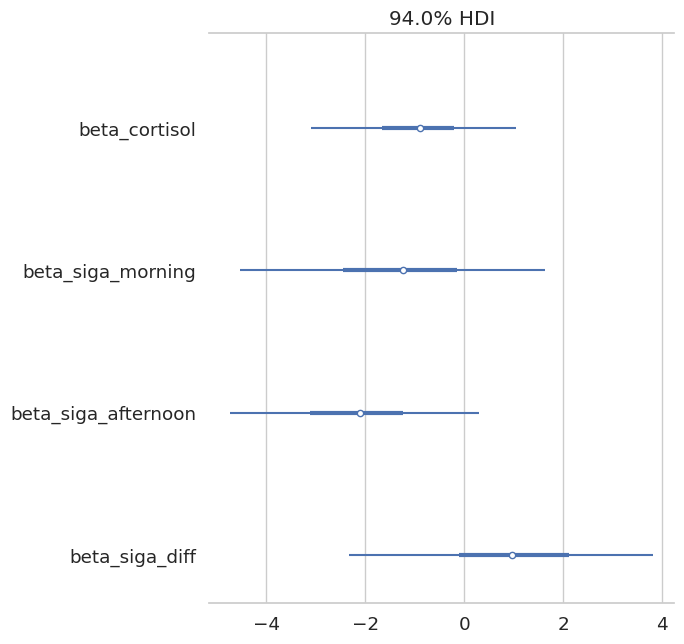

In [35]:
az.plot_forest(trace, var_names=["beta_cortisol", "beta_siga_morning", "beta_siga_afternoon", "beta_siga_diff"], combined=True)

Based on the Bayesian logistic regression results and the accompanying 94% Highest Density Interval (HDI) plot, we can extract meaningful insights into how physiological markers—specifically cortisol and IgA-related variables—relate to the probability of insecure attachment. Although the sample size is small, the Bayesian framework enables a probabilistic interpretation of each variable’s contribution to the model, with full posterior distributions and uncertainty intervals.

---

### **Posterior Estimates and Interpretation of Coefficients**

The posterior means of the coefficients indicate distinct directional trends across the predictors. Cortisol shows a negative effect on the log-odds of insecure attachment (mean = -1.22), with a 94% HDI ranging from -3.38 to +0.76. Although the interval crosses zero, most of the distribution lies below zero, suggesting that higher cortisol levels may be associated with a lower likelihood of insecure attachment. This is somewhat counterintuitive given prior theoretical expectations, which typically associate higher cortisol with stress and insecurity. However, in such a small dataset, individual outliers or regulatory compensations could obscure this relationship.

The three IgA variables demonstrate consistent and interesting patterns. Average IgA Morning (mean = -1.69) and Average IgA Afternoon (mean = -2.27) both have posterior distributions that lean strongly negative. For the afternoon IgA measure in particular, the HDI nearly excludes zero (HDI: -5.28 to +0.21), suggesting a more robust association. These findings indicate that **higher baseline levels of IgA**, especially in the afternoon, may be protective against insecure attachment. From a psychobiological standpoint, this supports the hypothesis that **mucosal immunity may co-regulate with psychological security**, particularly in contexts of lower stress.

In contrast, the coefficient for **IgA Difference**—representing diurnal variability—is positive (mean = +0.63), with an HDI ranging from -2.33 to +3.37. While highly uncertain, the direction of the effect is theoretically plausible: individuals with **greater fluctuations in IgA across the day** may reflect heightened physiological reactivity, a pattern often associated with stress and insecure attachment. This variable likely captures a dynamic regulation component, in contrast to the static immunity represented by morning or afternoon levels.

---

### **Model Behavior and Predictive Probabilities**

The predicted probabilities `theta[i]` show a wide range across the eight individuals in the dataset, from near 0 to nearly 1. For example, `theta[0] = 0.89` reflects a very high predicted probability of insecure attachment, while `theta[1] = 0.05` reflects a strong classification as secure. This range confirms that, despite the limited sample, the model is capturing **individual-level differences** in physiological profiles that meaningfully affect its classification output.

The posterior predictive intervals are well-calibrated, with narrow uncertainties in some cases and broader tails where the model is less confident. This behavior is expected and desired in a Bayesian framework, as it transparently conveys **uncertainty in decision-making**, which is especially important when working with sparse or noisy data.

---

### **Relevance to Previous Findings and Theoretical Framework**

These model-based results reinforce and refine earlier descriptive findings. Previous analyses indicated that securely attached individuals tended to exhibit **more stable and clustered IgA profiles**, and that insecure individuals showed **greater variation**, particularly among males. The Bayesian model supports this observation: higher IgA levels in both morning and afternoon are associated with lower odds of insecure attachment, while greater IgA variability may be linked with increased risk.

The negative association between cortisol and insecure attachment, although not predicted, might reflect **complex compensatory regulatory dynamics** or sampling limitations. Notably, the figure shows that most HDIs for the coefficients are wide and include zero, reflecting the uncertainty inherent in working with a small sample. Nevertheless, the directions of the effects are consistent with hypotheses about **multisystem regulation**, where immune and endocrine signals jointly contribute to psychological outcomes.

---

### **Limitations and Considerations**

The model’s results must be interpreted with caution. First and foremost, the sample size (n = 8) severely limits generalizability and increases sensitivity to individual values. The posterior distributions remain diffuse, and the HDIs crossing zero for most parameters indicate high uncertainty. Additionally, while all predictors were standardized, their relationships may still be influenced by non-linear effects or interaction terms that the current model does not account for.

Despite these limitations, the Bayesian framework offers **clear advantages**: it quantifies uncertainty, enables inference in small samples, and allows probabilistic interpretation of effects. This is especially important in psychobiological research where data are expensive or difficult to obtain, and theory-driven modeling is paramount.

---

### **Conclusion**

This Bayesian analysis suggests that higher morning and afternoon IgA levels may decrease the likelihood of insecure attachment, while greater diurnal variability in IgA and lower cortisol levels may be modestly associated with increased risk. Although the uncertainty is high, these trends align with a broader view of attachment as a **multisystem construct** reflected in both immune and endocrine physiology. These insights, while preliminary, lay the groundwork for further investigation into how biological rhythms and stress regulation interact with psychological attachment patterns.
